# Beamforming - Contre-mesures RADAR

## Emission dans les directions des échos RADAR

### Maxime BARRET


Avec l'aide de :
#### 'Signaux et Sytèmes' - Prof. Dr Ir Xavier Neyt 
#### 'Source Localization with sensor arrays' - Assistant Professors Charles Vanwynsberghe & Angélique Drémeau
#### Polarized Uniform Linear Array System: Beam Radiation Pattern, Beamforming Diversity Order, and Channel Capacity, Xin Su and KyungHi Chang

In [1]:
%matplotlib notebook
#Indique qu'on va afficher des figures, et permet de les modifier

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rd     
from scipy.signal import find_peaks
import time as t
import warnings
import scipy
from BeamformingMethods import a, compute_A, DP
from BeamformingMethods import CBF, MUSIC, MVDR
from BeamformingMethods import C_matrix
 #Imports d'usage

### Situation initiale

La situation est la suivante : 
- Nous émettons à l'aide Uniform Linear Array (ULA) décrit ci-après
- Nous avons une source, émetteur.
- Cette source doit éclairer deux cibles, dont les échos sont correlés. 
- 10 antennes dans mon array source
- d : distance entre mes antennes dans mon array
- Le problème est plan



### Description de notre ULA

Le principe du Beamforming est le même que dans le DoANotebook, ici on va juste jouer sur la phase de chaque émetteur pour créer le faisceau. 

![](Beam.jpg)

(Wikipedia)

Le principe utilisé pour générer un faisceau est simple : chaque émetteur de notre array va générer un même signal déphasé de tel sorte que deux émetteurs consécutifs aient une ddc de  $ dsin(\theta) $

### Déclaration de nos variables

En choisissant nos variables, nous devons faire attention à plusieurs choses :
- Rester cohérent avec la réalité : On ne va pas mettre 100000000 de capteurs, ni avoir une fréquence de 2 Hz
- Vérifier la condition d'échantillonnage spatial, ici : $ d < \dfrac{\lambda}{2} ) $


In [2]:
c0 = 3e8   #célérité de la lumière dans l'air 
d = 0.4          #Distance entre mes émetteurs
M1 = 10            #Nombre d'émetteurs sur un RADAR ennemi
N = 4*721
L = 512
angle = np.linspace(-np.pi/2,np.pi/2,N)     #Grille sur laquel on va chercher l'angle d'incidence

theta0 = 0   #Angle d'incidence auquel se situe le radar qu'on doit tromper : là, il est en face de la cible.
lam = 1  #Correspond à une fréquence de 300 Mhz, sachant qu'un radar se situe entre 300Mhz et 15 Ghz
         #Attention, la résolution du beamforming baisse si la fréquence est faible

#A priori, ce sont des paramètres qui ne sont pas amenés à bouger.

In [3]:
from BeamformingMethods import a, compute_A, DP

# I-  Direction d'émission

Dans un premier temps, nous allons illustrer la direction choisie.
Mes émetteurs, au nombre de 10, vont émettre un même signal s, mais déphasé, afin de générer un faisceau.
C'est un classic beamformer.

$$ \mathbf{s}(t) = \mathbf{A}_s * cos(\dfrac{2 \pi c_0}{\lambda} t)   + \mathbf{b} $$ 


Le déphasage entre 2 émetteurs consécutifs sera de 
$$ \mathbf{\Delta\phi} = \dfrac{2\pi d}{\lambda}sin(\theta) $$
pour traduire la différence de chemin de $ dsin(\theta) $

In [4]:
theta_e =  -np.pi/4  
sig_n = 3e-1   #Ecart-type de notre bruit, que je vais considérer Gaussien et additif

temp = rd.randn(M1,L)
s = np.array([scipy.signal.square(4*np.pi*c0*np.linspace(0,L,L)/lam)])
n = sig_n*(rd.randn(M1,L))  #Gaussien centré
delta_phi = 2*np.pi*d*np.sin(theta_e)/lam
steer = compute_A([theta_e],lam,M1)
y = steer@s +n 


On a un vecteur qui nous donne ce qui est émis par chaque émetteur de notre ULA pour L = 512 mesures



# II-  Émettre dans la DoA de l'écho RADAR de la cible

Il serait judicieux d'émettre dans la direction d'arrivée de l'écho RADAR.
Dans l'idée, il faudrait simuler deux cibles, dont les directions changeraient dans le temps, mais aussi simuler leurs écho RADAR.
Il faut utiliser les algorithmes de DoA pour avoir la (ou les) directions d'arrivées des échos, et émettre en fonction de cela. 

<IPython.core.display.Javascript object>


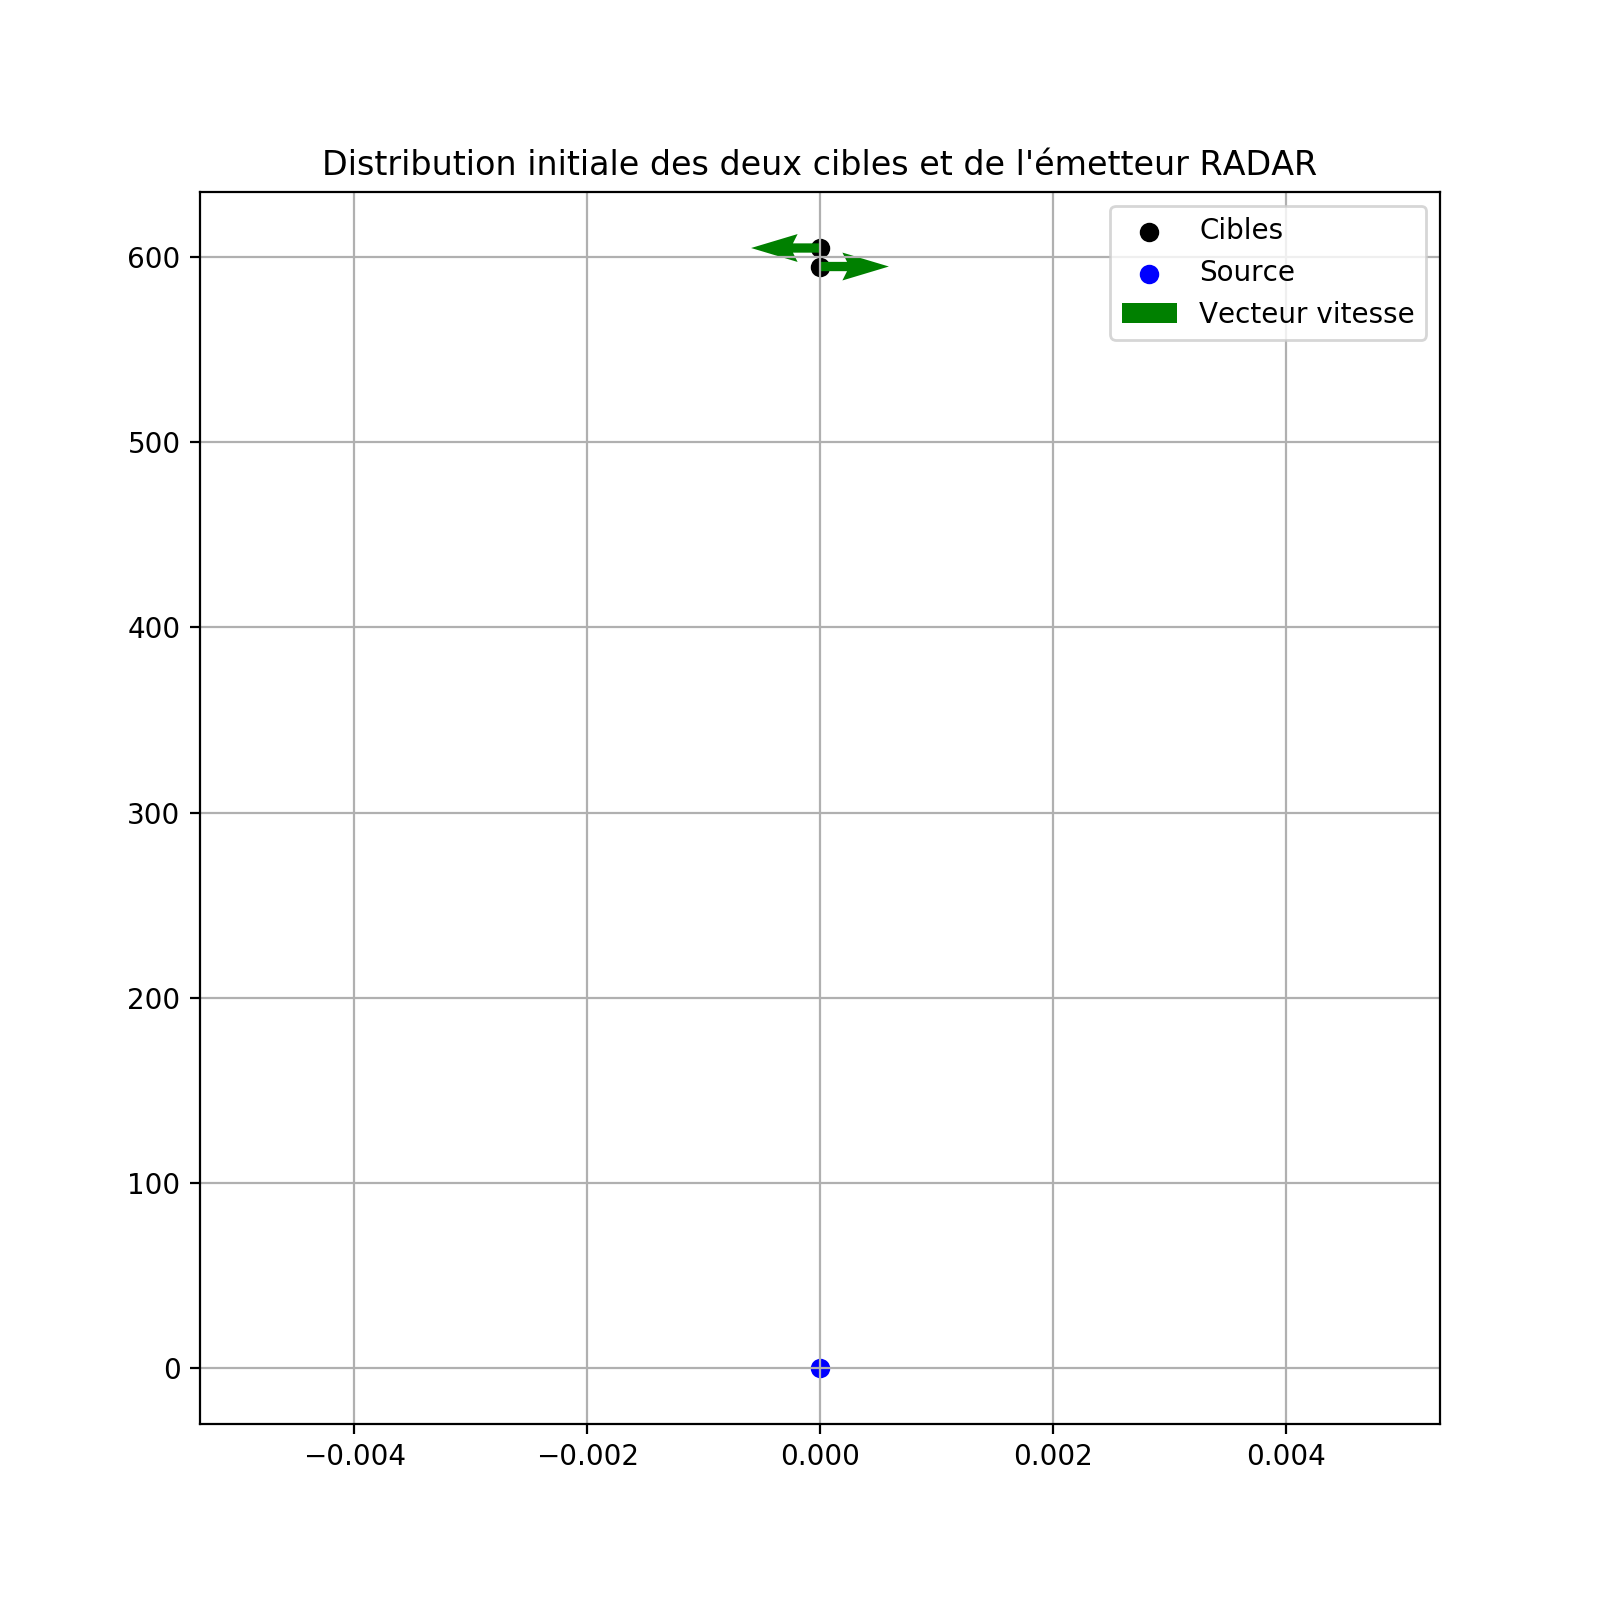

In [5]:
init_pos = [[0,0],[595,605]]  ## [[x1,x2],[y1,y2]]
nbCibles = 2
AmpEcho = [100,100]
v0 = 1.81
nbIter = 50

C_amp_mat, C_ang_mat = C_matrix(nbCibles,AmpEcho,init_pos,v0,nbIter)

plt.figure(figsize=(8,8))
plt.title("Distribution initiale des deux cibles et de l'émetteur RADAR")
plt.scatter(init_pos[0],init_pos[1],color='k',label='Cibles')
plt.scatter(0,0,color='b',label='Source')
plt.quiver(0,595,v0,0,color='g',label='Vecteur vitesse')
plt.quiver(0,605,-v0,0,color='g')
plt.grid()
plt.legend()
plt.show()

In [6]:
DOA = []
DOAmu = []
DOAmv = []
Peaks = []
for t in range(nbIter):
    DOA.append(CBF(C_ang_mat[t],C_amp_mat[t],sig_n,N,M1,nbCibles,L,lam,[v0,0,0]))
    DOAmu.append(MUSIC(C_ang_mat[t],C_amp_mat[t],sig_n,N,M1,nbCibles,L,lam,[v0,0,0]))
    DOAmv.append(MVDR(C_ang_mat[t],C_amp_mat[t],sig_n,N,M1,nbCibles,L,lam,[v0,0,0]))
    Peaks.append(angle[find_peaks(DOA[t],prominence=0.4)[0]])

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


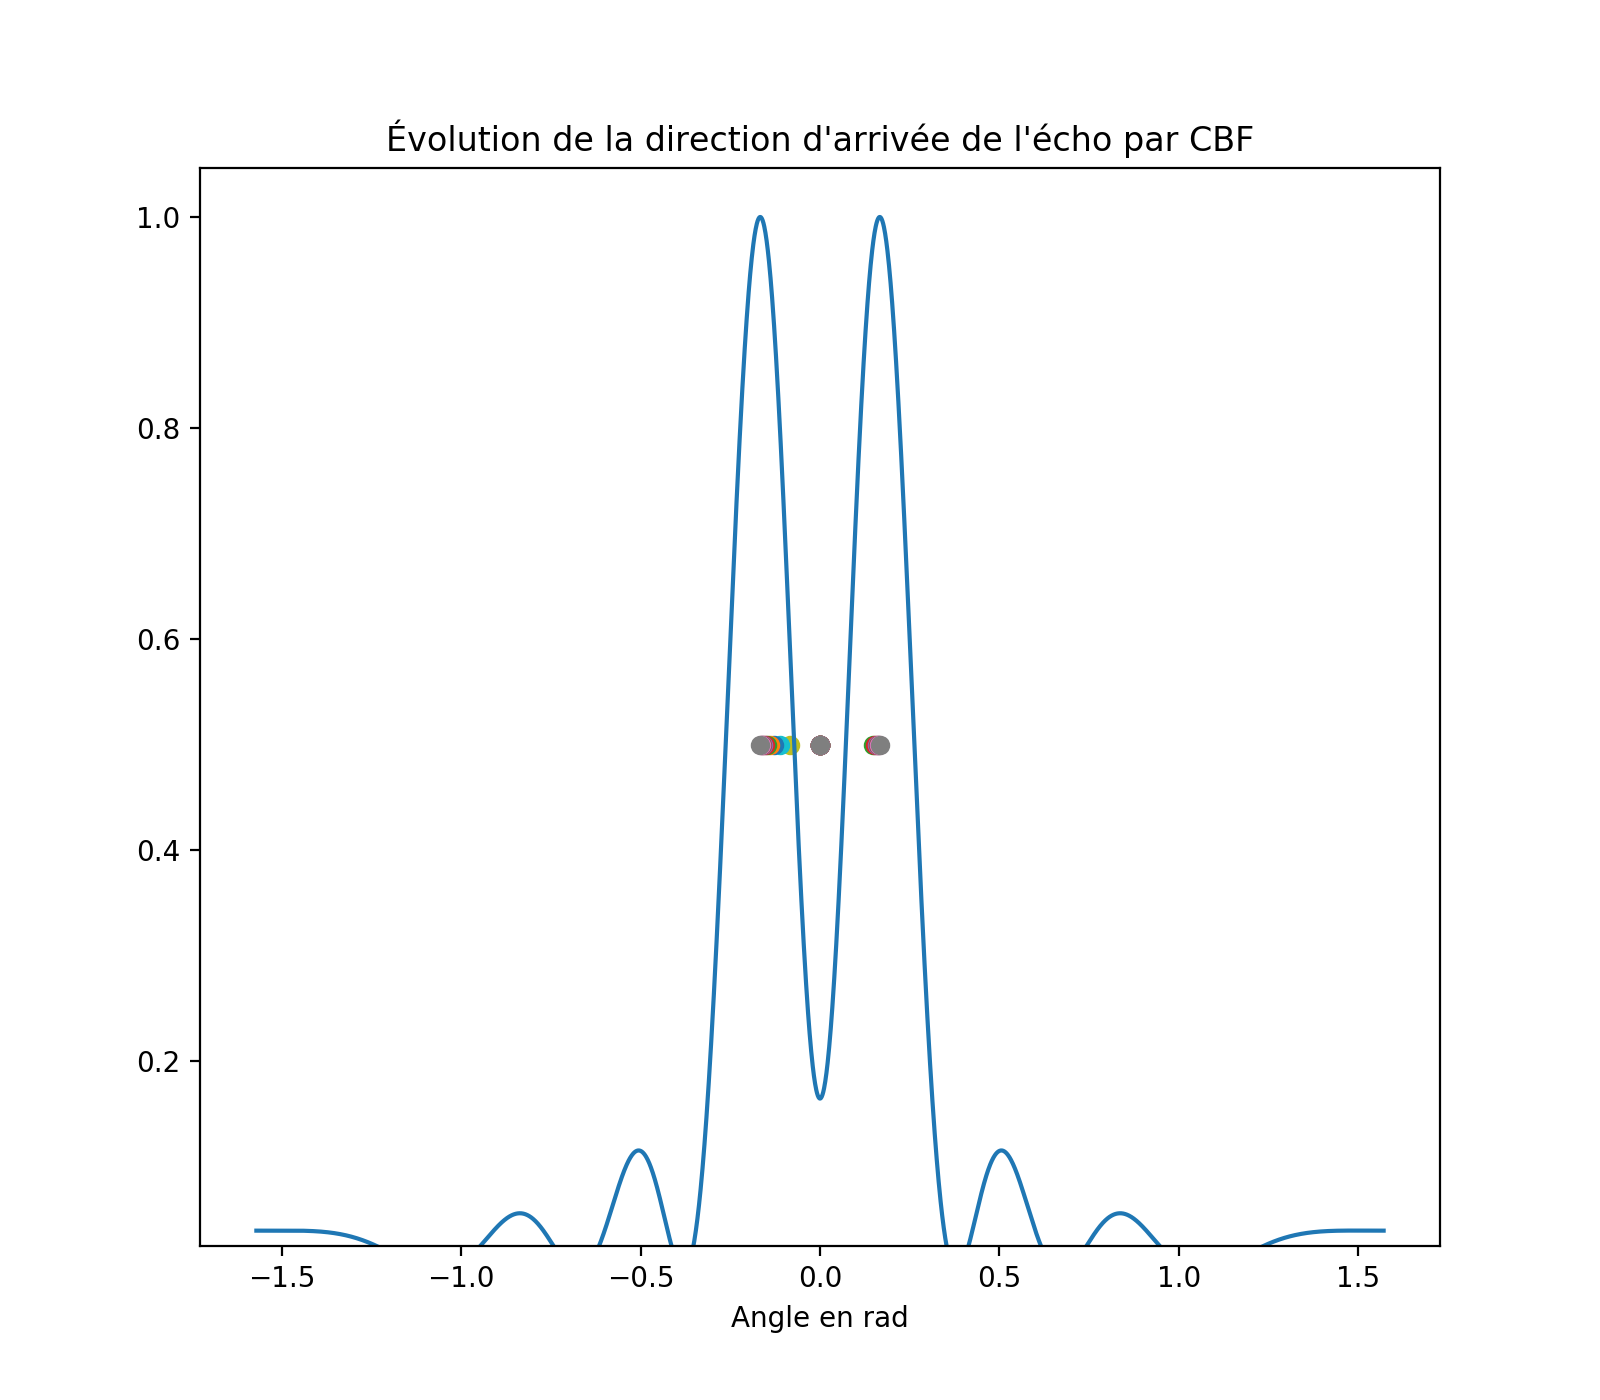

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [7]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8,7))
plt.xlabel("Angle en rad")
plt.title("Deux cibles à Éclairer")
line, = ax.plot(angle, DOA[0])


def animate(i):
    line.set_ydata(DOA[i])  # update the data
    plt.scatter(Peaks[i],len(Peaks[i])*[0.5])
    return line,

def init():
    line.set_ydata(np.ma.array(angle, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 50), init_func=init,interval=200, blit=True)
plt.title("Évolution de la direction d'arrivée de l'écho par CBF")
plt.show()

A cette vitesse, et pour le temps considéré, on voit bien la séparation do lobe principal de la fonction $P_{CBF}$. Avant de se séparer en plusieurs pics, on a une augmentation de la largeur du lobe. On peut mesurer cette augmentation en calculant la largeur à mi-hauteur du pic. 


In [8]:
def HMFW(plot):
    """
    A partir d'une courbe de PCBF, renvoie la liste des couples d'abscisses délimitant les extrémités d'un pic.
    :param plot: 1D array of CBF values
    :return: list of abscissa where the plot is equal to 0.5 
    """
    temp = []
    for i,value in enumerate(np.abs(plot)):
        if np.abs(value-0.5)<5e-3 and angle[i-1] not in temp:
            temp.append(angle[i])
    l = len(temp)
    print(l)
    return temp

2
2
4


<IPython.core.display.Javascript object>


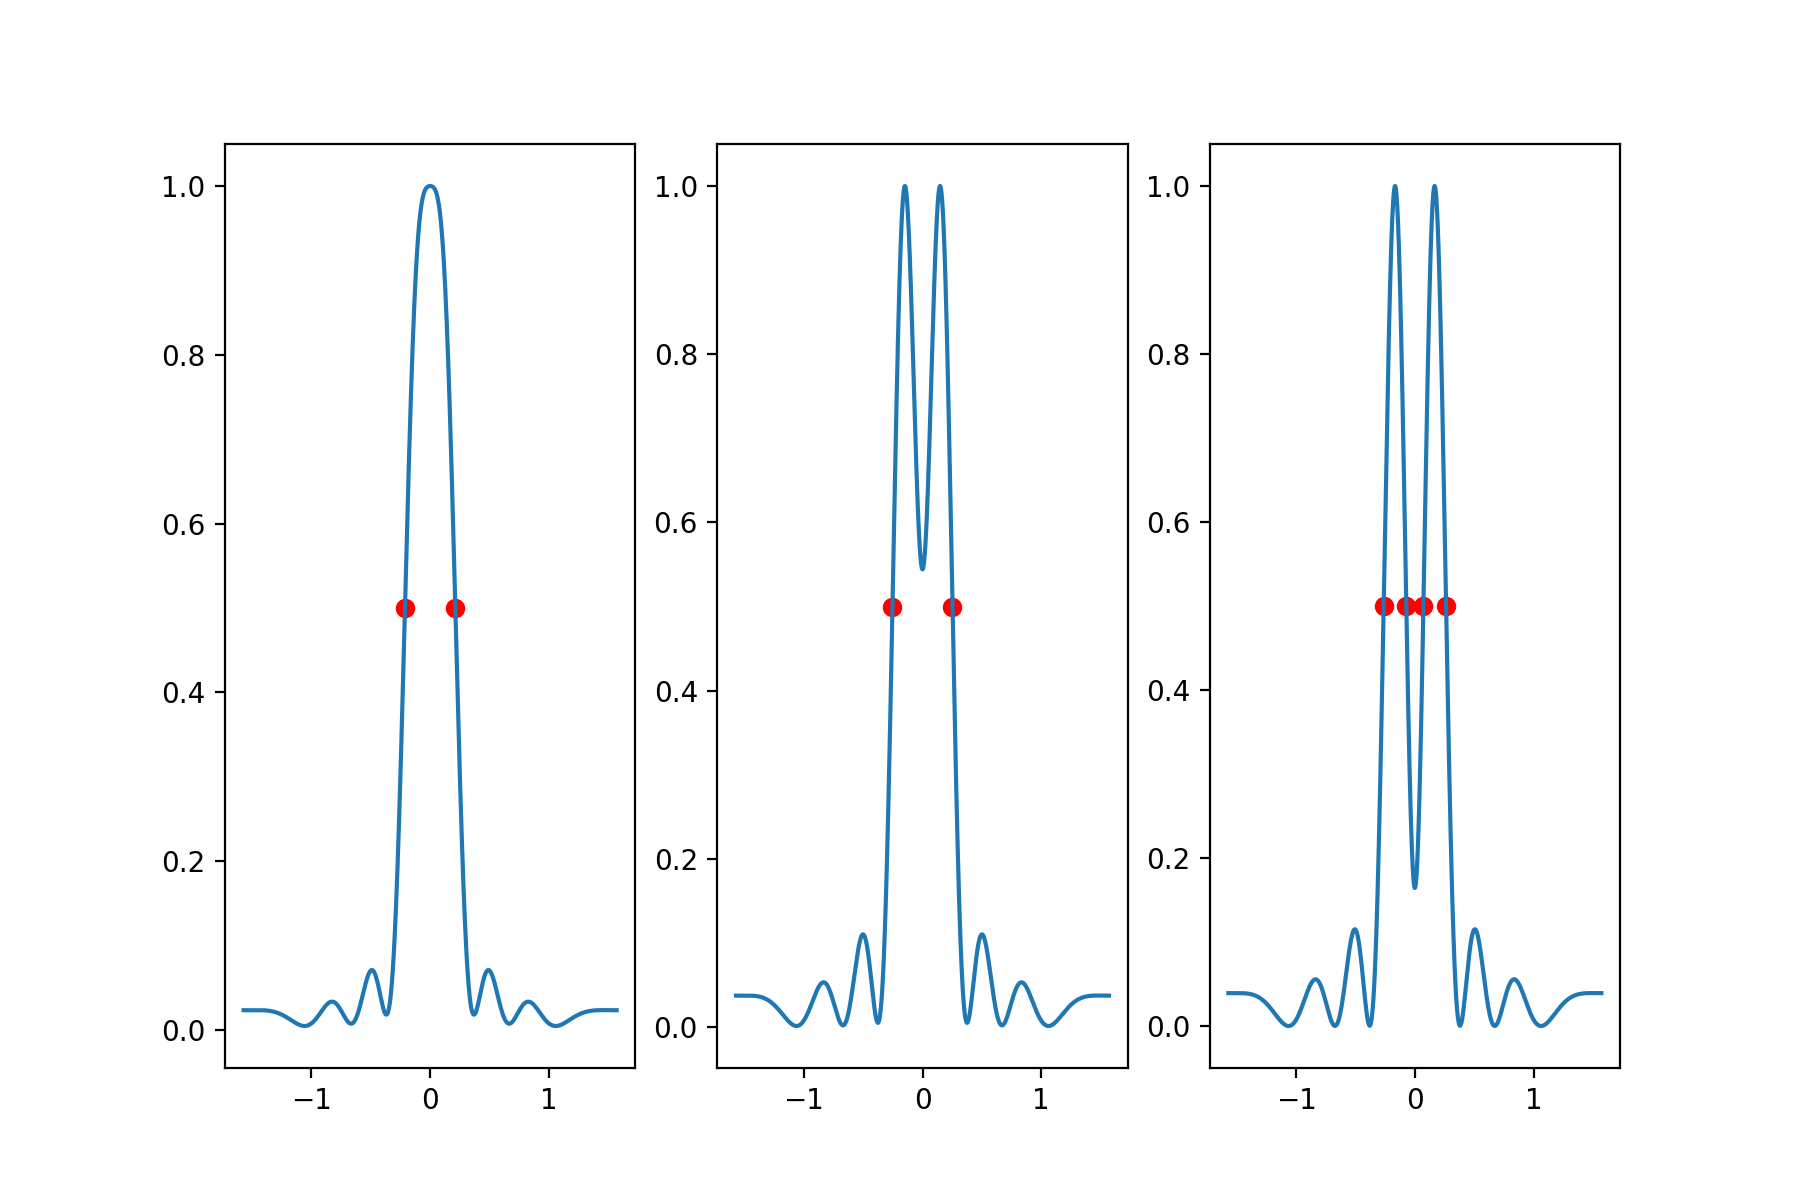

In [9]:
ind = 28   #Séparation du lobe en deux, à l'indice 29


plot1 = DOA[ind]
plot2 = DOA[ind+5]
plot3 = DOA[ind+10]
test1 = HMFW(plot1)
test2 = HMFW(plot2)
test3 = HMFW(plot3)

plt.figure(figsize=(9,6))
plt.title("évolution de la taille des lobes")
plt.subplot(131)
plt.plot(angle,DOA[ind])
plt.scatter(test1,len(test1)*[0.5],color='r')
plt.subplot(132)
plt.plot(angle,DOA[ind+5])
plt.scatter(test2,len(test2)*[0.5],color='r')
plt.subplot(133)
plt.plot(angle,DOA[ind+10])
plt.scatter(test3,len(test3)*[0.5],color='r')

#### Peut-on observer des effets particuliers avec la méthode MUSIC ? 

J'ai stocké les données MUSIC correspondant à la situation précédente dans $DOAmu$, voyons ce que cela donne 

<IPython.core.display.Javascript object>


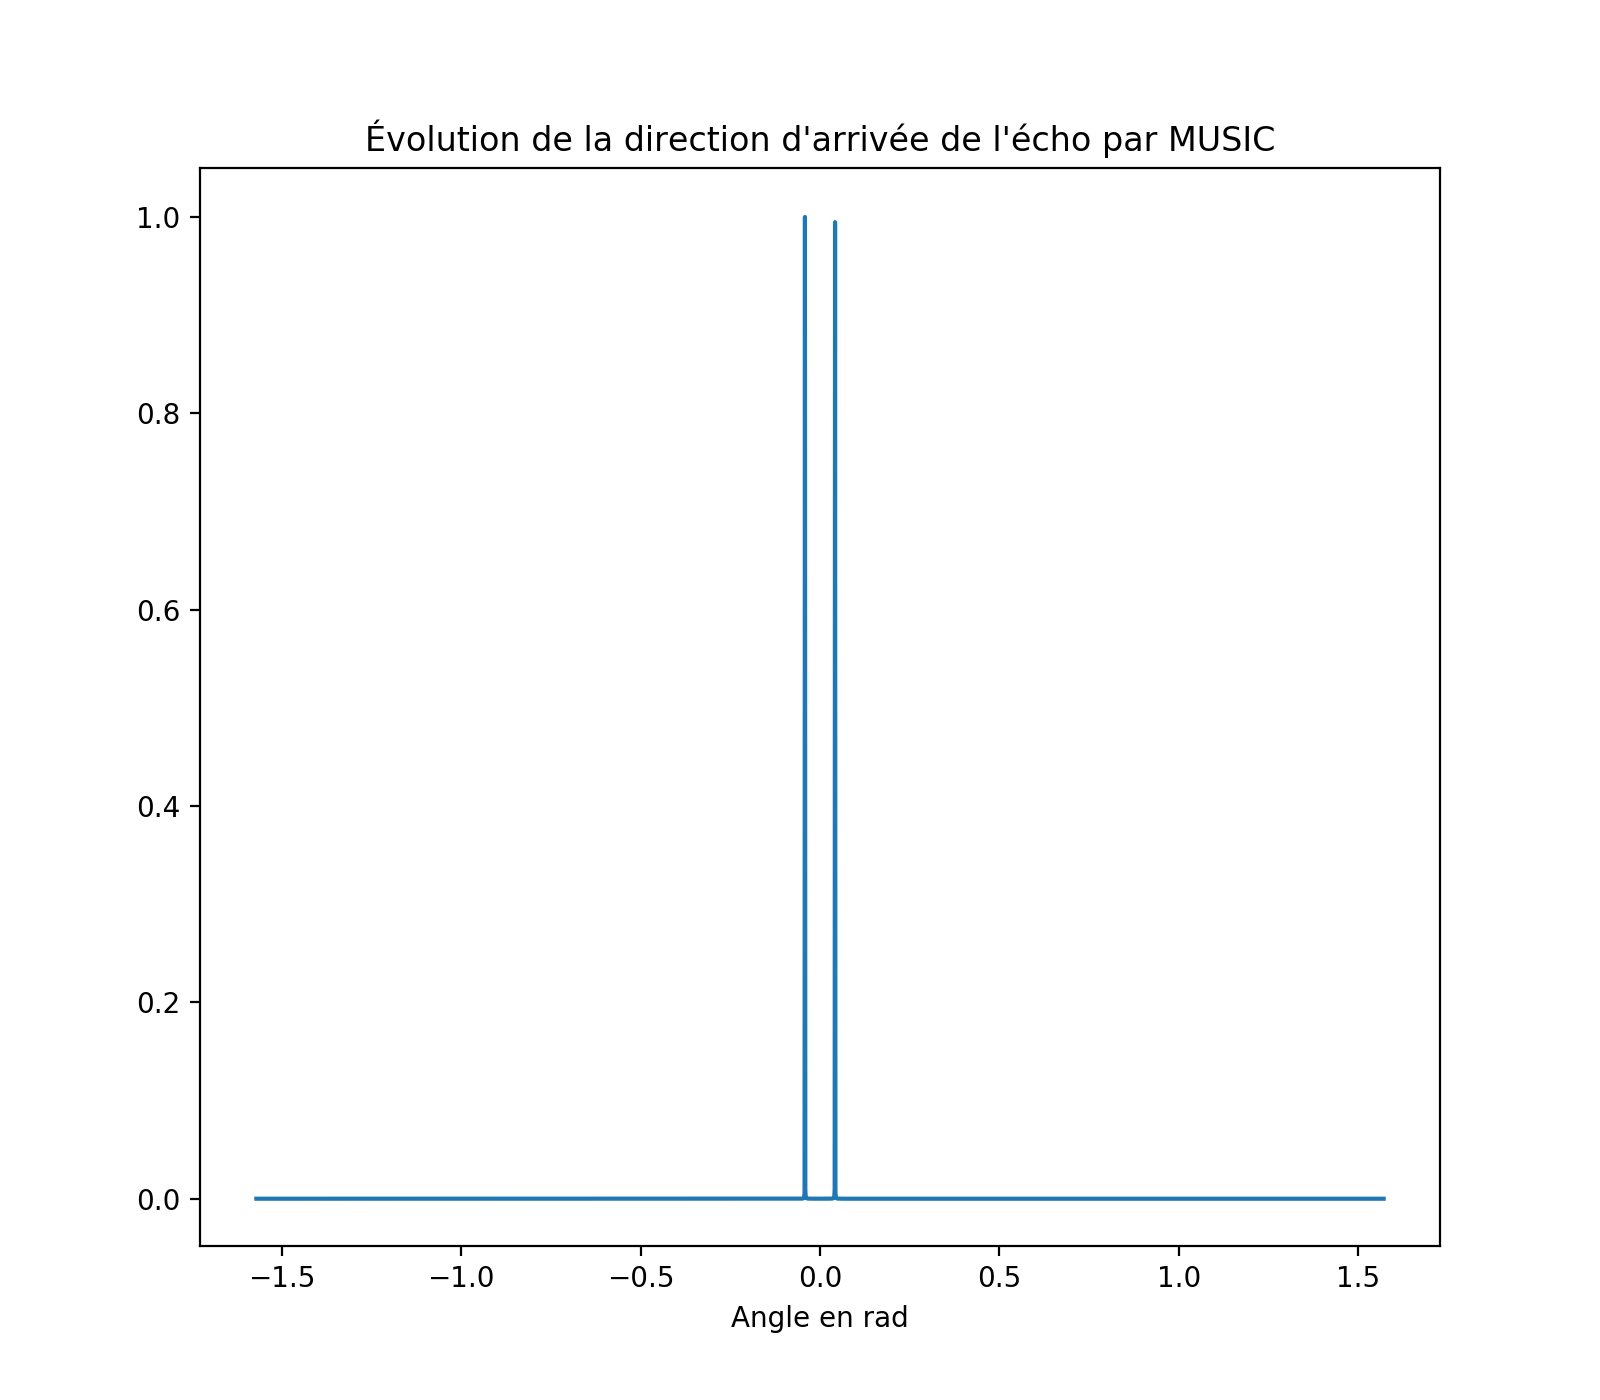

In [11]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8,7))
plt.xlabel("Angle en rad")
plt.title("Deux cibles à Éclairer")
line, = ax.plot(angle, DOAmu[0])


def animate(i):
    line.set_ydata(DOAmu[i])  # update the data
    return line,

def init():
    line.set_ydata(np.ma.array(angle, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 50), init_func=init,interval=200, blit=True)
plt.title("Évolution de la direction d'arrivée de l'écho par MUSIC")
plt.show()

Rien de particulier comme phénomène avec cette méthode.

Et avec MVDR ? 

<IPython.core.display.Javascript object>


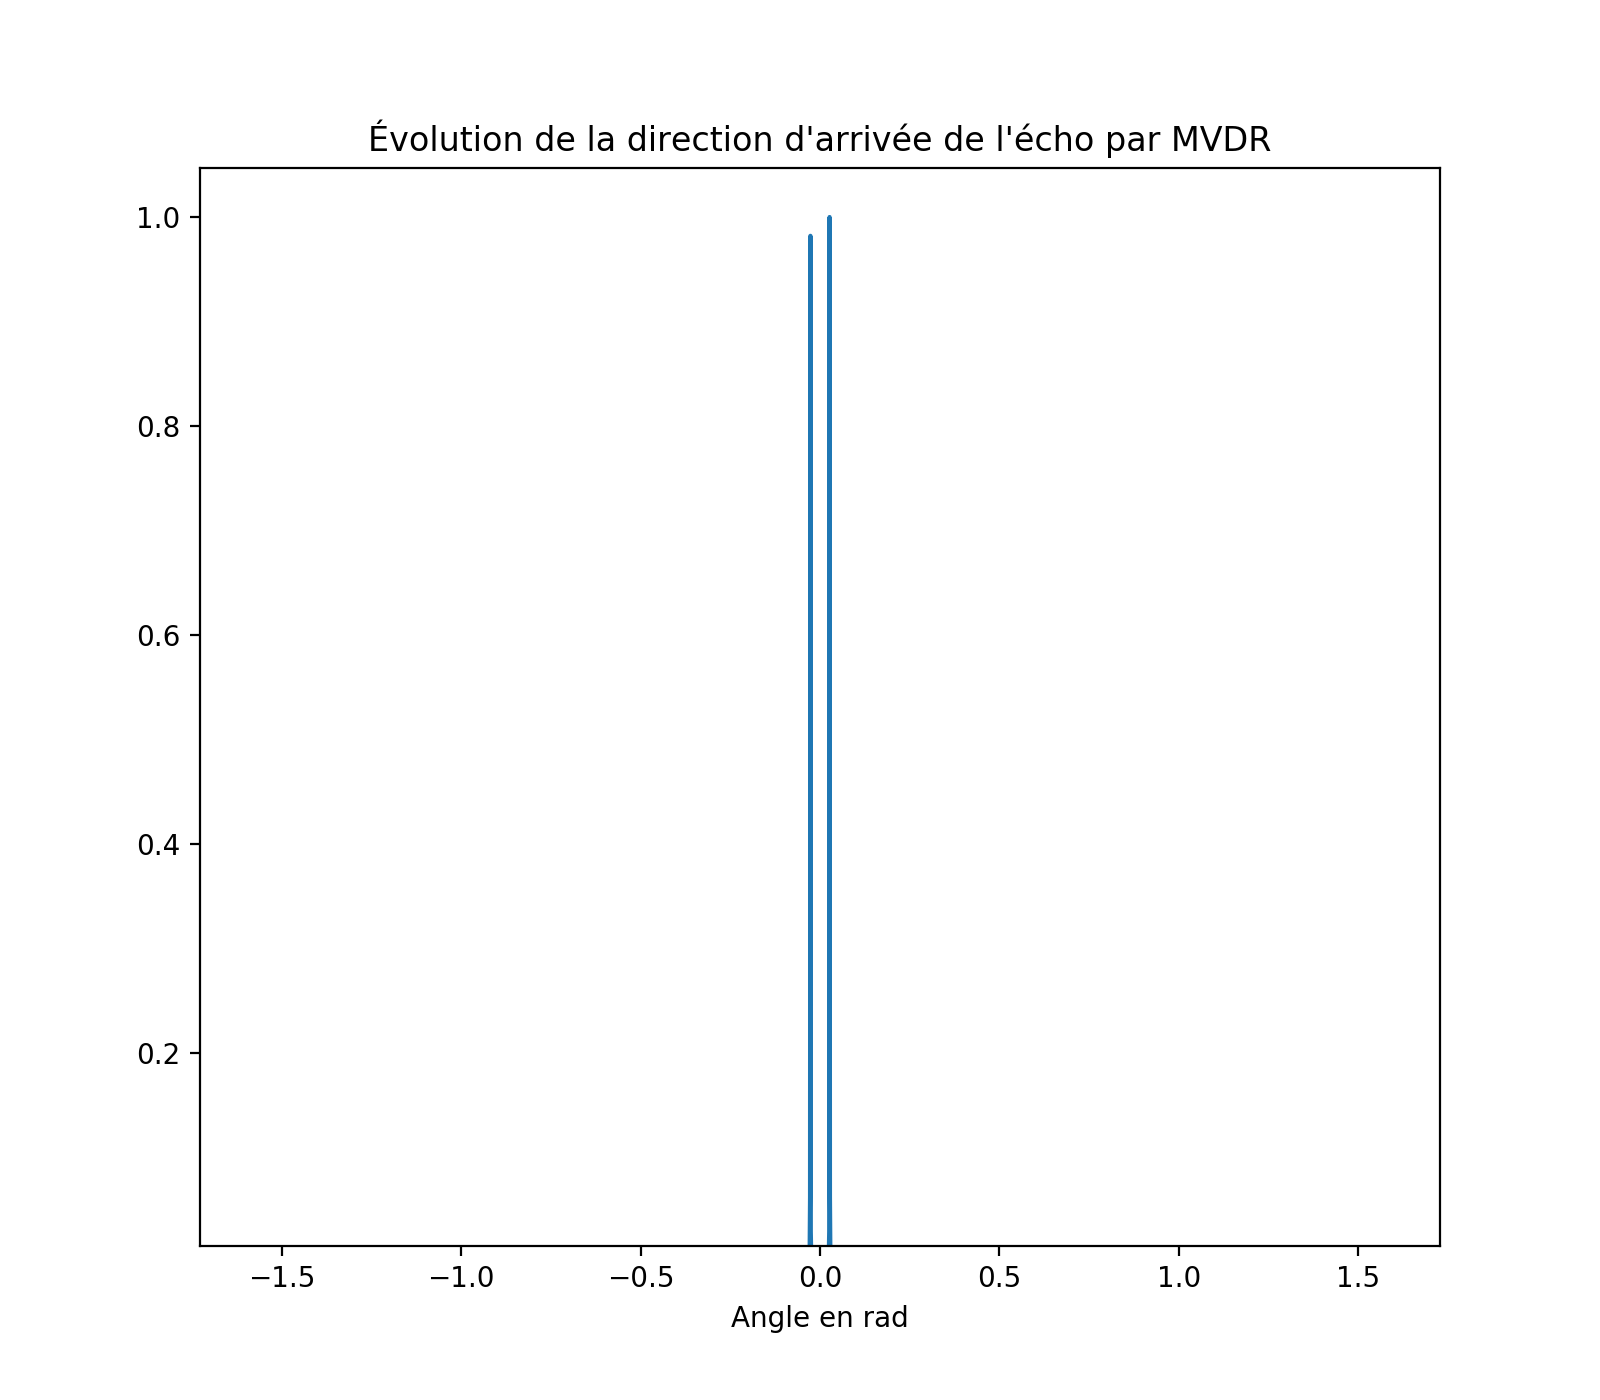

In [12]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8,7))
plt.xlabel("Angle en rad")
plt.title("Deux cibles à Éclairer")
line, = ax.plot(angle, DOAmv[0])


def animate(i):
    line.set_ydata(DOAmv[i])  # update the data
    return line,

def init():
    line.set_ydata(np.ma.array(angle, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 50), init_func=init,interval=200, blit=True)
plt.title("Évolution de la direction d'arrivée de l'écho par MVDR")
plt.show()

Là non plus, pas grand chose. 

## Les observations restent-elles les mêmes si les cibles sont plus éloignées qu'il n'y parait ?


<IPython.core.display.Javascript object>


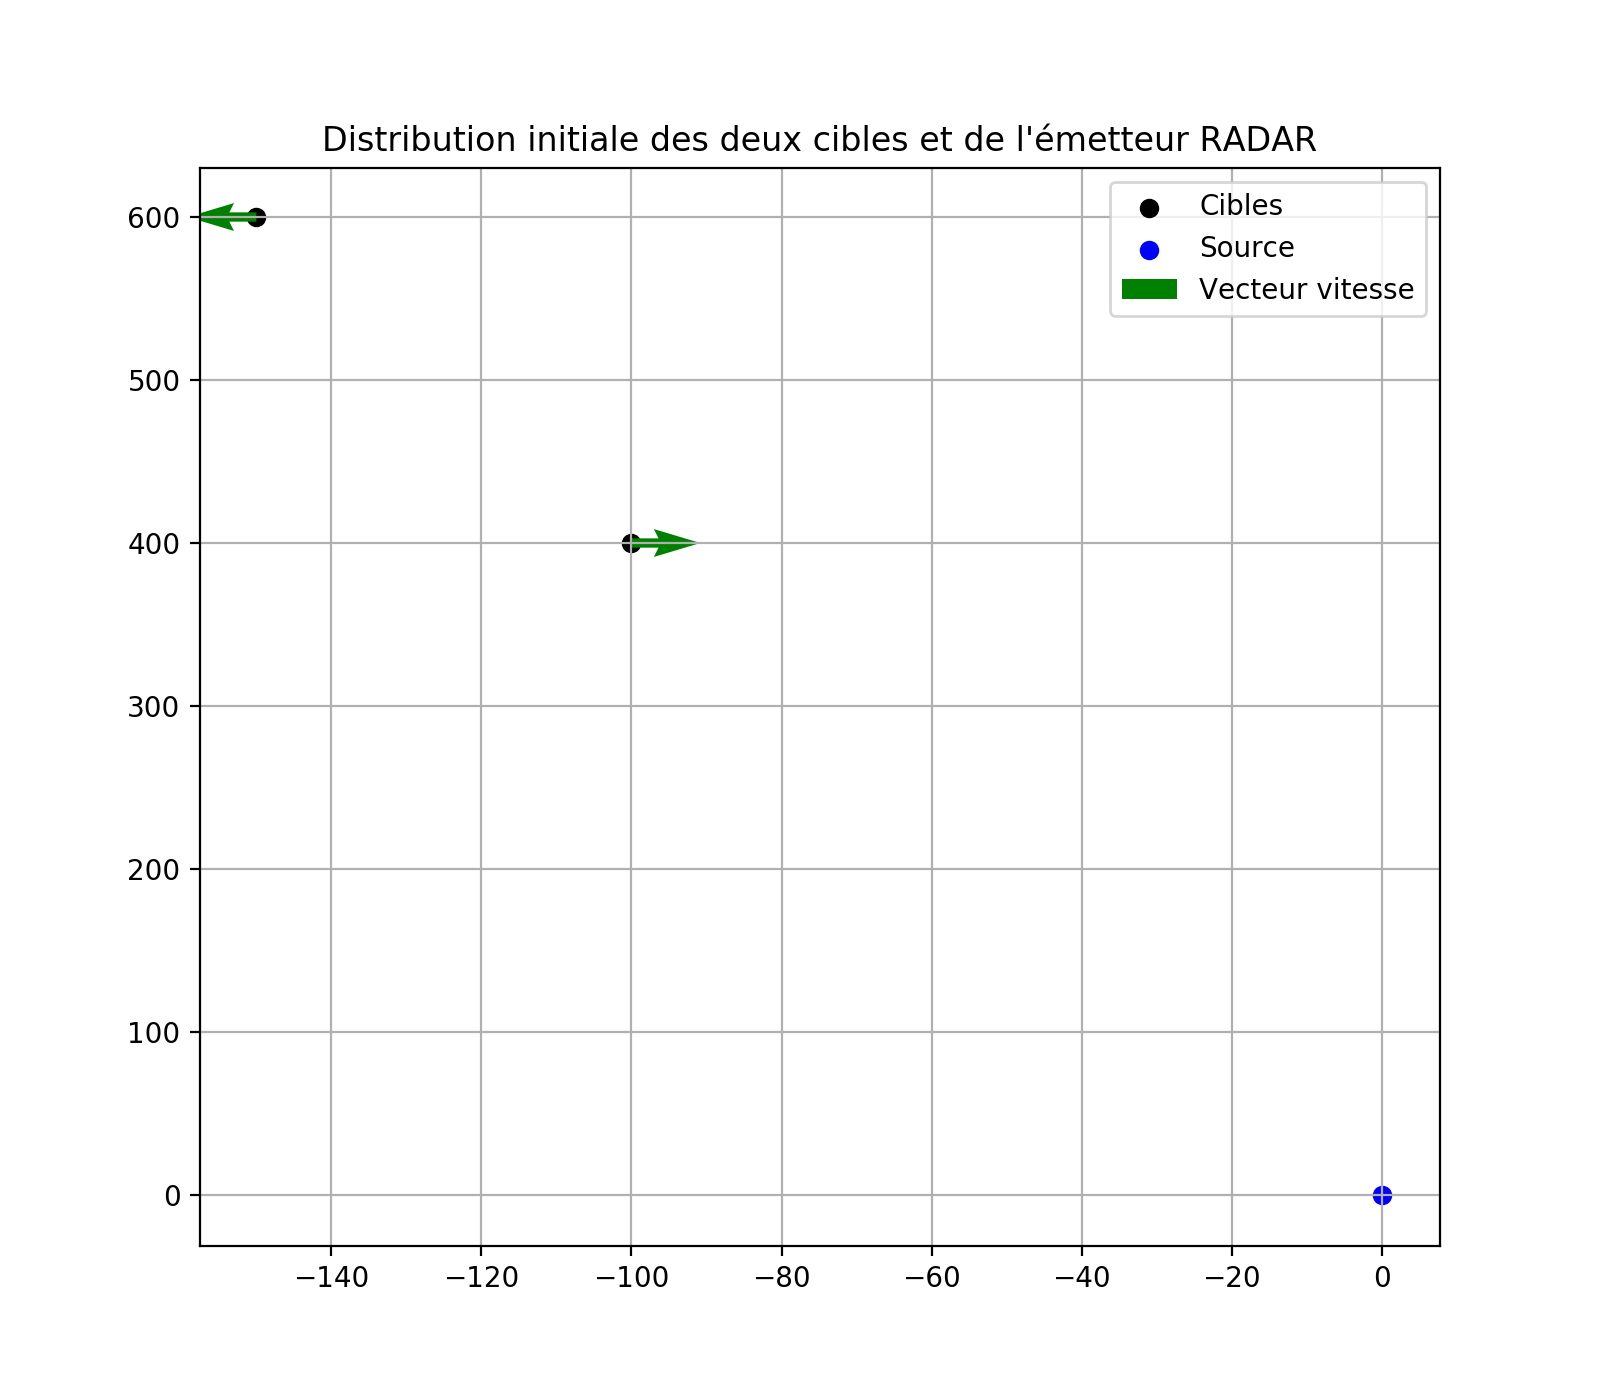

In [13]:
init_pos = [[-150,-100],[600,400]]
nbCibles = 2
AmpEcho = [100,100]
v0 = 1.81
nbIter = 50

C_amp_mat2, C_ang_mat2 = C_matrix(nbCibles,AmpEcho,init_pos,v0,nbIter)

plt.figure(figsize=(8,7))
plt.title("Distribution initiale des deux cibles et de l'émetteur RADAR")
plt.scatter(init_pos[0],init_pos[1],color='k',label='Cibles')
plt.scatter(0,0,color='b',label='Source')
plt.quiver(-100,400,v0,0,color='g',label='Vecteur vitesse')
plt.quiver(-150,600,-v0,0,color='g')
plt.grid()
plt.legend()
plt.show()



In [14]:
DOA2 = []
DOAmu2 = []
DOAmv2 = []
Peaks2 = []
for t in range(nbIter):
    DOA2.append(CBF(C_ang_mat2[t],C_amp_mat2[t],sig_n,N,M1,nbCibles,L,lam,[v0,0,0]))
    DOAmu2.append(MUSIC(C_ang_mat2[t],C_amp_mat2[t],sig_n,N,M1,nbCibles,L,lam,[v0,0,0]))
    DOAmv2.append(MVDR(C_ang_mat2[t],C_amp_mat2[t],sig_n,N,M1,nbCibles,L,lam,[v0,0,0]))
    Peaks2.append(angle[find_peaks(DOA2[t],prominence=0.4)[0]])

<IPython.core.display.Javascript object>


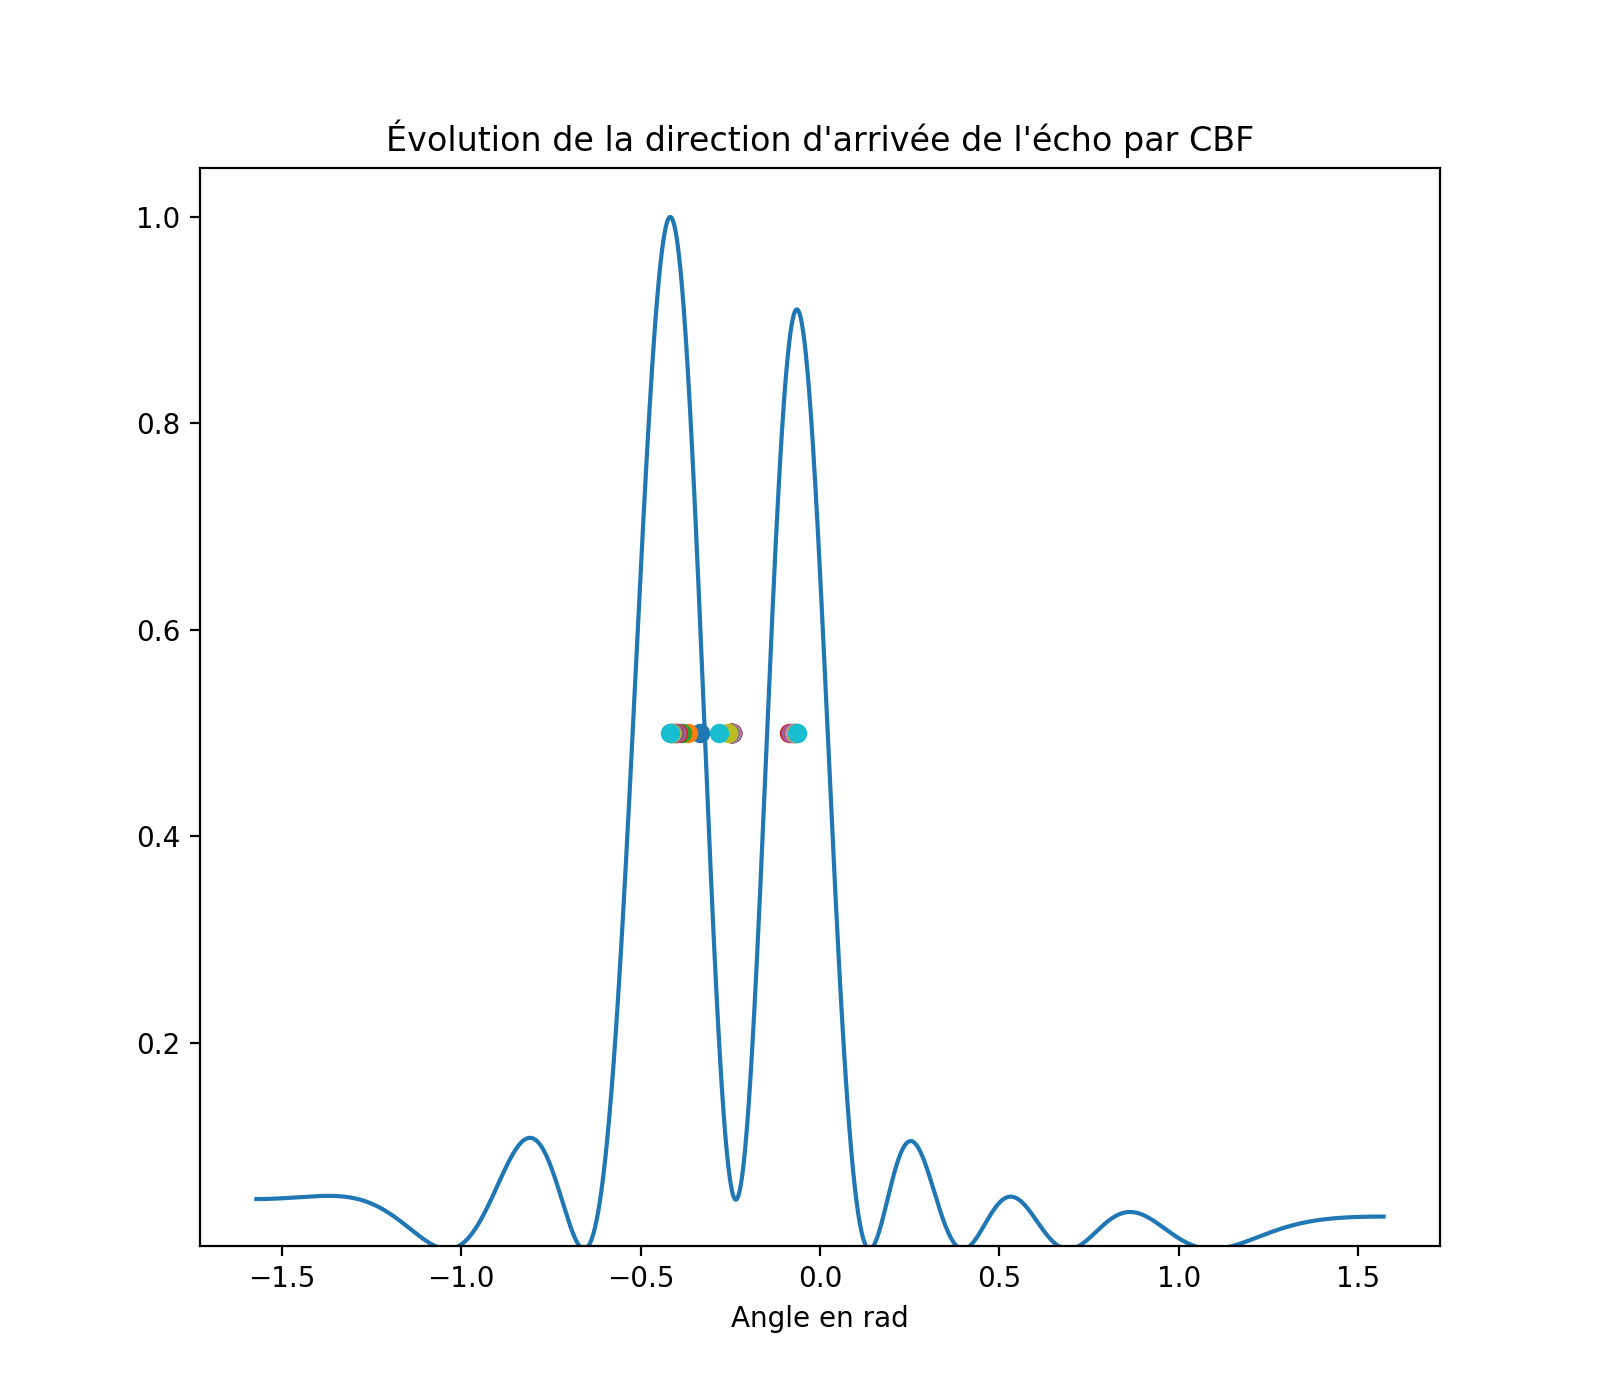

In [15]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8,7))
plt.xlabel("Angle en rad")
plt.title("Deux cibles à Éclairer")
line, = ax.plot(angle, DOA2[0])


def animate(i):
    line.set_ydata(DOA2[i])  # update the data
    plt.scatter(Peaks2[i],len(Peaks2[i])*[0.5])
    return line,

def init():
    line.set_ydata(np.ma.array(angle, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 50), init_func=init,interval=200, blit=True)
plt.title("Évolution de la direction d'arrivée de l'écho par CBF")
plt.show()



# III- Maintenant, émettons dans cette (ou ces) directions

On a stocké nos directions dans le vecteur $Peaks$, et nous pouvons générer le signal sur chaque émetteur de façon à créer un faisceau dans les bonnes directions. 


In [10]:
from BeamformingMethods import transmit


In [11]:
DOA = []
Peaks = []
Emission = []
for t in range(nbIter):
    DOA.append(CBF(C_ang_mat[t],C_amp_mat[t],sig_n,N,M1,nbCibles,L,lam,[v0,0,0]))
    Peaks.append(angle[find_peaks(DOA[t],prominence=0.4)[0]])
    Emission.append(transmit(Peaks[-1],M1,L))



### TODO : Faire en sorte d'afficher les directions du plan d'ondes, pour illustrer les faisceaux... Parce que pour l'instant, on me croit sur parole. 

In [1]:
transmit??

Object `transmit` not found.


In [13]:
yt = transmit(Peaks[-1],M1,L)